In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

In [2]:
import sys
sys.path.append("../")
from config import DATASETS_PATH, ASSETS_PATH, COLOURS

In [3]:
MY_ASSETS_PATH = os.path.join(ASSETS_PATH, 'data_exploration_and_analysis')
LABELS_PATH = os.path.join(DATASETS_PATH, 'labels.csv')
labels_df = pd.read_csv(LABELS_PATH)

In [ ]:
labels_df.head() # view format

### Identify and fix errors

In [ ]:
# first replace all empty string with NaN
labels_df = labels_df.replace(r'^\s*$', np.nan, regex=True)

In [ ]:
# test number of non-empty image names matches number of training images
TRAIN_IMGS_PATH = os.path.join(DATASETS_PATH, 'train')
n_images = len(os.listdir(TRAIN_IMGS_PATH))
n_image_names = pd.notnull(labels_df["image_name"]).sum()
assert n_images == n_image_names

In [ ]:
# test whether an image is labelled twice
n_duplicated = labels_df["image_name"].duplicated().sum()
assert n_duplicated == 0

In [ ]:
# check if any image does not have assigned labels
n_empty = pd.isnull(labels_df["tags"]).sum()
assert n_empty == 0

### Labels

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

In [5]:
# labels in the dataset
vectorizer.fit(labels_df['tags'].to_list())
labels = vectorizer.get_feature_names()
print(labels)

['agriculture', 'artisinal_mine', 'bare_ground', 'blooming', 'blow_down', 'clear', 'cloudy', 'conventional_mine', 'cultivation', 'habitation', 'haze', 'partly_cloudy', 'primary', 'road', 'selective_logging', 'slash_burn', 'water']


In [11]:
len(labels) - 4

13

### Reformat dataset
replace single column of tags to multiple columns with indicator variables for each tag (label)

In [6]:
# first remove any possible duplicates
def remove_string_duplicates(s):
    return ' '.join((set(s.split())))

labels_df['tags'] = labels_df['tags'].apply(remove_string_duplicates)

In [7]:
indicator_values = vectorizer.transform(labels_df['tags'])
indicator_df = pd.DataFrame(data=indicator_values.todense(), columns=labels)
indicator_df = pd.concat([labels_df, indicator_df], axis="columns")
indicator_df.head()

,image_name,tags,agriculture,artisinal_mine,bare_ground,blooming,blow_down,clear,cloudy,conventional_mine,cultivation,habitation,haze,partly_cloudy,primary,road,selective_logging,slash_burn,water
0,train_0,primary haze,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0
1,train_1,primary clear agriculture water,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1
2,train_2,primary clear,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
3,train_3,primary clear,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
4,train_4,primary agriculture habitation road clear,1,0,0,0,0,1,0,0,0,1,0,0,1,1,0,0,0


In [ ]:
# output to csv for future use
indicator_labels_path = os.path.join(DATASETS_PATH, 'indicator_labels.csv')
indicator_df.to_csv(indicator_labels_path, index=False)

### Label distribution

In [8]:
label_count = indicator_df[labels].sum(axis = 0)
label_count.sort_values(ascending=False, inplace=True)
sorted_labels = label_count.index.tolist()

Text(0, 0.5, 'Frequency')

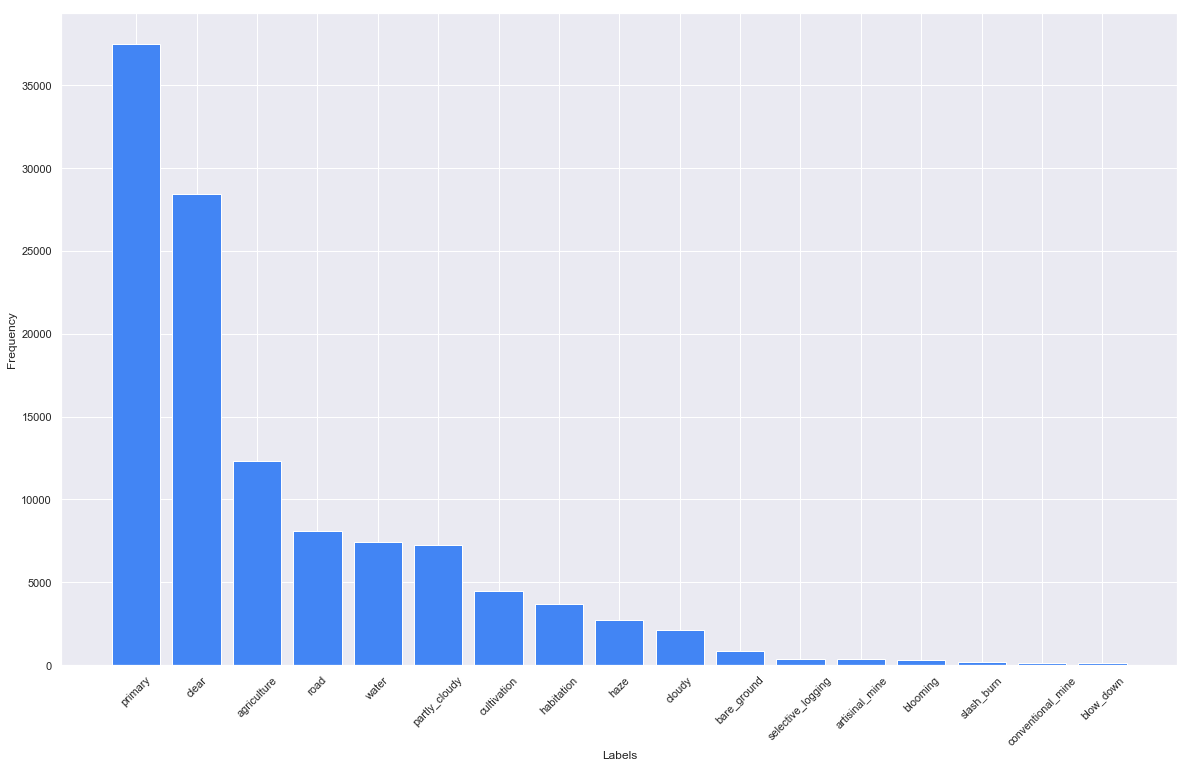

In [9]:
fig_label_distribution = plt.figure(figsize=(20, 12))
plt.bar(sorted_labels, label_count, color=COLOURS['blue'])
plt.xticks(rotation=45)
plt.xlabel('Labels')
plt.ylabel('Frequency')

In [10]:
label_distribution_path = os.path.join(MY_ASSETS_PATH, 'label_distribution.png')
fig_label_distribution.savefig(label_distribution_path, dpi=300)

### Label realtions

In [ ]:
indicator_vals_df = indicator_df[labels].reindex(sorted_labels, axis=1)
label_coocurrance = indicator_vals_df.T.dot(indicator_vals_df)

In [ ]:
label_coocurrance

In [ ]:
fig_coocurrance = sns.heatmap(label_coocurrance)

Because the primary and clear labels are so dominant over the rest the regular co-ocurrance matrix does not provide us much information on the relation between the labels. We can expose more information by crating a new matrix which shows **what percentage of the label on the Y axis also has the label on the X axis**

In [ ]:
label_relations = (label_coocurrance.T / label_count).T

In [ ]:
sns.set(rc={'figure.figsize':(16,12)})
fig_relations = sns.heatmap(label_relations, cmap=sns.light_palette(COLOURS['blue'], 10))

In [ ]:
label_relations_path = os.path.join(MY_ASSETS_PATH, 'label_relations.png')
fig_relations.get_figure().savefig(label_relations_path, dpi=300)